# Key Question 1: Bleeding

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

rseeds = [20090425, 19700903]

In [2]:
data_file = 'data/Tonsillectomy_KQ5_Bleeding_Data_07202016.xlsx'

raw_data = (pd.read_excel(data_file, 
              sheetname='Bleeding_Dexa vs Placebo_KQ5', 
              na_values=['null', 'ND']))
raw_data.shape

(48, 16)

In [3]:
raw_data.head()

,Citation,REFID,Number_ of_Arms,Rx_Grouping,Group_Desc,Intervention_category,Dose,Route,Rx_Durn,OUTC_Main_ CATG,Outc_SUB_ CATG,New_Bleeding_specify,Outcome_timepoint,OUTCOME_SAMPLE_SIZE,Outcome_count,Outcome_%
0,"T. Q. Gallagher, C. Hill, S. Ojha, E. Ference,...",1039,2,G1:,dexamethasone,perioperative steroid,0.5 mg/kg,Injection,NaN,Harms,Harms: Post-op bleeding,Primary bleeding,POD5,154,2,1.0
1,"T. Q. Gallagher, C. Hill, S. Ojha, E. Ference,...",1039,2,G2:,placebo (saline),placebo,0.5 mg/kg,Injection,NaN,Harms,Harms: Post-op bleeding,Primary bleeding,POD5,151,2,1.0
2,"T. Q. Gallagher, C. Hill, S. Ojha, E. Ference,...",1039,2,G1:,dexamethasone,perioperative steroid,0.5 mg/kg,Injection,NaN,Harms,Harms: Post-op bleeding,Undefined bleeding,POD5,154,15,9.7
3,"T. Q. Gallagher, C. Hill, S. Ojha, E. Ference,...",1039,2,G2:,placebo (saline),placebo,0.5 mg/kg,Injection,NaN,Harms,Harms: Post-op bleeding,Undefined bleeding,POD5,151,11,7.3
4,"T. Q. Gallagher, C. Hill, S. Ojha, E. Ference,...",1039,2,G1:,dexamethasone,perioperative steroid,0.5 mg/kg,Injection,NaN,Harms,Harms: Post-op bleeding,Revisit/Readmission-bleeding,POD5,154,3,1.9


Unique study IDs

In [4]:
raw_data.REFID.unique()

array([ 1039,  1085,  2213,  3031,  3213,  3498,  6452,  6586, 12791])

IDs of high risk of bias studies

In [5]:
high_ROB = 6586, 12791

Counts of intervention arms

In [6]:
raw_data.Intervention_category.value_counts()

perioperative steroid    27
placebo                  21
Name: Intervention_category, dtype: int64

We will estimate bleeding rates using a binomial model. We will assume bleeding type-specific baseline rates of bleeding, and optionally bleeding-type specific intervention effects, which can be pooled if desired. Additionally, we include study random effects to account for correlation among arms in the same study. 

In [7]:
from pymc3 import Model, sample, traceplot, forestplot, summary, waic
from pymc3 import Normal, Binomial, invlogit, HalfCauchy, Deterministic, exp

def create_model(_data, bleeding_specific=False):
    
    data = _data.copy()
    
    unique_studies = data.REFID.unique()
    n_studies = len(unique_studies)
    
    bleeding = data.New_Bleeding_specify.unique()
    n_bleeding = len(bleeding)
    
    data['study_id'] = data.REFID.replace(dict(zip(unique_studies, range(n_studies))))
    data['bleeding_type'] = (data.New_Bleeding_specify
                             .replace(dict(zip(bleeding, range(n_bleeding)))))
    
    data['treatment'] = (data.Intervention_category=='perioperative steroid').astype(int)
    
    b, t, i, n, y = data[['bleeding_type', 'treatment', 
                          'study_id', 'OUTCOME_SAMPLE_SIZE', 'Outcome_count']].T.values
    
    with Model() as model:

        # Study random effect
        σ = HalfCauchy('σ', 5)
        ϵ = Normal('ϵ', 0, sd=σ, shape=n_studies)
        
        # Bleeding type means
        μ = Normal('μ', 0, sd=100, shape=n_bleeding)

        if bleeding_specific:
            # Perioperative steroid effect
            δ = Normal('δ', 0, sd=100, shape=n_bleeding)

            θ = invlogit(μ[b] + δ[b]*t + ϵ[i])
        else:
            # Perioperative steroid effect
            δ = Normal('δ', 0, sd=100)

            θ = invlogit(μ[b] + δ*t + ϵ[i])
        
        data_likelhood = Binomial('data_likelihood', n=n, p=θ, observed=y)
        
        odds = Deterministic('odds', exp(δ))
        
    return model

### Pooled effect size, all studies

In [8]:
pooled_model = create_model(raw_data)

Applied log-transform to σ and added transformed σ_log_ to model.


In [9]:
with pooled_model:
    
    pooled_trace = sample(2000, njobs=2, random_seed=rseeds)

Assigned NUTS to σ_log_
Assigned NUTS to ϵ
Assigned NUTS to μ
Assigned NUTS to δ
 [-----------------100%-----------------] 2000 of 2000 complete in 59.5 sec

Intervention odds ratio of the pooled model

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1245869b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x125370940>]], dtype=object)

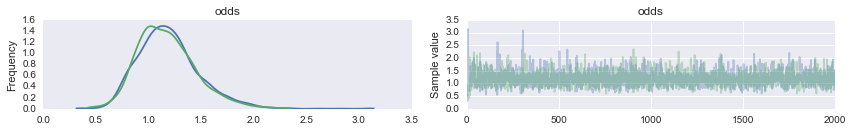

In [10]:
traceplot(pooled_trace, varnames=['odds'])

In [11]:
summary(pooled_trace, varnames=['odds'])


odds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.183            0.286            0.006            [0.700, 1.783]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.719          0.985          1.155          1.342          1.843



In [12]:
waic(pooled_trace, model=pooled_model)

435.59452469113387

### Pooled effect size, exclude high ROB studies

Here we exclude study arms from the high risk of bias studies.

In [13]:
low_rob_model = create_model(raw_data[~raw_data.REFID.isin(high_ROB)])

Applied log-transform to σ and added transformed σ_log_ to model.


In [14]:
with low_rob_model:
    
    low_rob_trace = sample(2000, njobs=2, random_seed=rseeds)

Assigned NUTS to σ_log_
Assigned NUTS to ϵ
Assigned NUTS to μ
Assigned NUTS to δ
 [-----------------100%-----------------] 2000 of 2000 complete in 60.8 sec

The odds ratio is not very different from the full model.

In [15]:
summary(low_rob_trace, varnames=['odds'])


odds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.220            0.296            0.005            [0.667, 1.792]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.742          1.016          1.188          1.387          1.898



In [16]:
waic(low_rob_trace, model=low_rob_model)

322.60856772998176

## Bleeding-specific effects, all studies

This model is generalized to allow the intervention to be bleeding-type specific. We are using the full dataset.

In [17]:
full_model = create_model(raw_data, bleeding_specific=True)

Applied log-transform to σ and added transformed σ_log_ to model.


In [18]:
with full_model:
    
    full_trace = sample(2000, njobs=2, random_seed=rseeds)

Assigned NUTS to σ_log_
Assigned NUTS to ϵ
Assigned NUTS to μ
Assigned NUTS to δ
 [-----------------100%-----------------] 2000 of 2000 complete in 81.2 sec

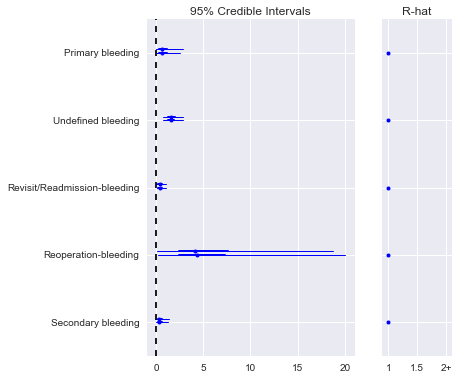

In [19]:
forestplot(full_trace, varnames=['odds'], ylabels=raw_data.New_Bleeding_specify.unique())

In [20]:
summary(full_trace, varnames=['odds'])


odds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.953            1.289            0.031            [0.009, 2.700]
  1.683            0.593            0.009            [0.715, 2.857]
  0.474            0.316            0.005            [0.043, 1.069]
  6.639            9.217            0.273            [0.314, 19.184]
  0.465            0.479            0.010            [0.007, 1.321]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.073          0.320          0.601          1.151          3.819
  0.834          1.265          1.578          1.984          3.126
  0.100          0.256          0.399          0.604          1.291
  0.968          2.427          4.164          7.386          27.248
  0.038          0.170          0.333          0.587          1.713



In [21]:
waic(full_trace, model=full_model)

391.25973015219506

## Goodness of fit

To check the internal validity of the estimates, we calculate posterior predictive checks on the data, relative to data simulated from the model.

In [22]:
from pymc3 import sample_ppc

full_ppc = sample_ppc(full_trace, model=full_model, samples=500)

In [23]:
bayes_p = lambda sim, true: [(s > t).mean() for s,t in zip(sim, true)]

sim_days = full_ppc['data_likelihood']
sim_days.shape

(500, 48)

In [24]:
(sim_days < raw_data.Outcome_count.values).mean(0)

array([ 0.622,  0.39 ,  0.55 ,  0.708,  0.502,  0.274,  0.286,  0.386,
        0.   ,  0.   ,  0.618,  0.   ,  0.   ,  0.944,  0.38 ,  0.018,
        0.96 ,  0.11 ,  0.698,  0.186,  0.888,  0.   ,  0.   ,  0.   ,
        0.   ,  0.454,  0.   ,  0.52 ,  0.   ,  0.848,  0.   ,  0.61 ,
        0.   ,  0.   ,  0.   ,  0.678,  0.   ,  0.79 ,  0.   ,  0.   ,
        0.846,  0.558,  0.   ,  0.   ,  0.   ,  0.852,  0.   ,  0.   ])

The fit of this model is very poor, as evidenced by the zeros.

## Mixture model

The issues from the model above is the prevalence of zeros in the bleeding counts. There appears to be a mixture of outcomes, one of which never results in bleeding, and the other which may (according to the binomial model). The model below, a **zero-inflated binomial** model, accounts for this.

In [44]:
from pymc3 import Model, sample, traceplot, forestplot, summary, waic, DensityDist
from pymc3 import Normal, Binomial, invlogit, HalfCauchy, Deterministic, exp, Beta, log
import theano.tensor as tt

def create_zib_model(_data, bleeding_specific=False, dose_effect=False):
    
    data = _data.copy()
    
    unique_studies = data.REFID.unique()
    n_studies = len(unique_studies)
    
    bleeding = data.New_Bleeding_specify.unique()
    n_bleeding = len(bleeding)
    
    dose = data.Dose.fillna('0 mg/kg').apply(lambda x: float(x.split(' ')[0])).values
    
    data['study_id'] = data.REFID.replace(dict(zip(unique_studies, range(n_studies))))
    data['bleeding_type'] = (data.New_Bleeding_specify
                             .replace(dict(zip(bleeding, range(n_bleeding)))))
    
    data['treatment'] = (data.Intervention_category=='perioperative steroid').astype(int)
    
    b, t, i, n, y = data[['bleeding_type', 'treatment', 
                          'study_id', 'OUTCOME_SAMPLE_SIZE', 'Outcome_count']].T.values
    
    with Model() as model:
        
        # Probability of bleeding population
        ψ = Beta('ψ', 1, 1)

        # Study random effect
        σ = HalfCauchy('σ', 5)
        ϵ = Normal('ϵ', 0, sd=σ, shape=n_studies)
        
        # Bleeding type means
        μ = Normal('μ', 0, sd=100, shape=n_bleeding)
        
        # Dose effect
        α = Normal('α', 0, sd=100) if dose_effect else 0

        if bleeding_specific:
            # Perioperative steroid effect
            δ = Normal('δ', 0, sd=100, shape=n_bleeding)

            θ = invlogit(μ[b] + δ[b]*t + α*dose + ϵ[i])
        else:
            # Perioperative steroid effect
            δ = Normal('δ', 0, sd=100)

            θ = invlogit(μ[b] + δ*t + α*dose + ϵ[i])
            
        def zero_inflated_binomial(value):
            return tt.switch(value>0, log(ψ) + Binomial.dist(n=n, p=θ).logp(value),
                                    log((1-ψ)) * (1-θ)**n).sum()
        
        data_likelhood = DensityDist('data_likelihood', zero_inflated_binomial, observed=y)
        
        odds = Deterministic('odds', exp(δ))
        
    return model

In [26]:
full_zib_model = create_zib_model(raw_data, bleeding_specific=True)

Applied logodds-transform to ψ and added transformed ψ_logodds_ to model.
Applied log-transform to σ and added transformed σ_log_ to model.


In [27]:
with full_zib_model:
    
    full_zib_trace = sample(2000)

Assigned NUTS to ψ_logodds_
Assigned NUTS to σ_log_
Assigned NUTS to ϵ
Assigned NUTS to μ
Assigned NUTS to δ
 [-----------------100%-----------------] 2000 of 2000 complete in 140.9 sec

On average, 16% have no chance of bleeding outcome.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12d82f470>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12cffc2e8>]], dtype=object)

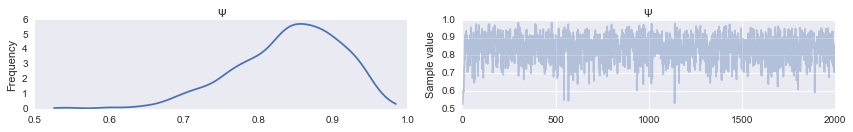

In [28]:
traceplot(full_zib_trace, varnames=['ψ'])

In [31]:
summary(full_zib_trace, varnames=['ψ'])


ψ:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.841            0.072            0.002            [0.701, 0.962]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.685          0.798          0.850          0.894          0.952



Conditional on the potential for bleeding, here are the bleeding-specific effect sizes of the steroid intervention.

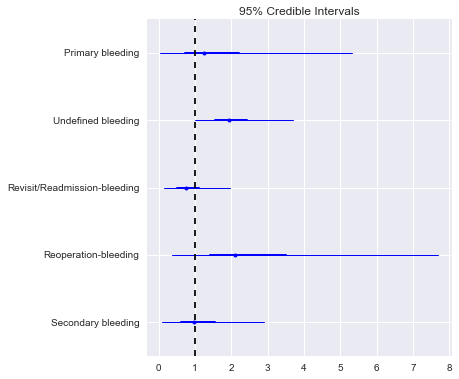

In [29]:
forestplot(full_zib_trace, varnames=['odds'], 
           ylabels=raw_data.New_Bleeding_specify.unique(), vline=1)

In [30]:
summary(full_zib_trace, varnames=['odds'])


odds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.856            2.397            0.090            [0.050, 5.309]
  2.080            0.728            0.023            [0.989, 3.688]
  0.878            0.523            0.018            [0.145, 1.968]
  3.019            3.250            0.150            [0.356, 7.687]
  1.218            0.942            0.025            [0.095, 2.895]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.186          0.716          1.251          2.214          6.760
  1.063          1.559          1.944          2.441          3.915
  0.224          0.503          0.761          1.110          2.274
  0.687          1.419          2.109          3.513          10.887
  0.232          0.615          0.972          1.538          3.555



In [50]:
waic(full_zib_trace, model=full_zib_model)

4837.1111089253127

Below is the best model so far: bleeding-specific effect sizes, along with a dose effect covariate.

In [51]:
full_zib_bleeding_model = create_zib_model(raw_data, bleeding_specific=True, dose_effect=True)

Applied logodds-transform to ψ and added transformed ψ_logodds_ to model.
Applied log-transform to σ and added transformed σ_log_ to model.


In [52]:
with full_zib_bleeding_model:
    
    full_zib_bleeding_trace = sample(2000)

Assigned NUTS to ψ_logodds_
Assigned NUTS to σ_log_
Assigned NUTS to ϵ
Assigned NUTS to μ
Assigned NUTS to α
Assigned NUTS to δ
 [-----------------100%-----------------] 2000 of 2000 complete in 168.9 sec

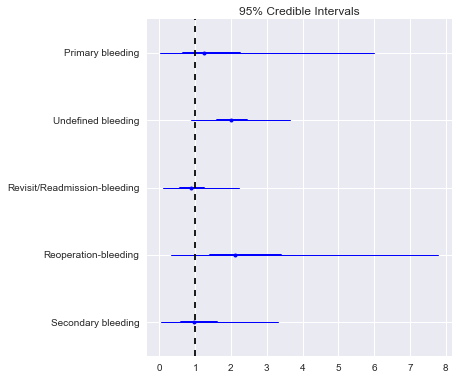

In [56]:
forestplot(full_zib_bleeding_trace, varnames=['odds'], 
           ylabels=raw_data.New_Bleeding_specify.unique(), vline=1)

In [54]:
summary(full_zib_bleeding_trace, varnames=['odds'])


odds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.933            2.387            0.099            [0.028, 5.989]
  2.112            0.748            0.021            [0.892, 3.651]
  1.007            0.655            0.020            [0.102, 2.218]
  3.146            5.011            0.223            [0.333, 7.784]
  1.305            1.224            0.034            [0.040, 3.324]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.173          0.669          1.258          2.244          8.033
  1.045          1.603          1.987          2.458          3.937
  0.216          0.562          0.872          1.257          2.712
  0.718          1.420          2.109          3.389          11.540
  0.222          0.603          0.973          1.612          4.466



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x145fff748>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x14618e550>]], dtype=object)

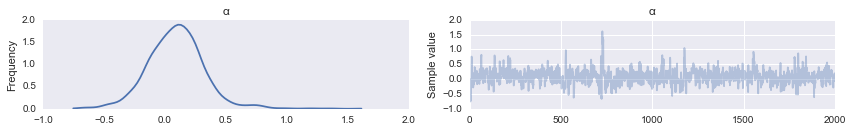

In [55]:
traceplot(full_zib_bleeding_trace, varnames=['α'])

In [53]:
waic(full_zib_bleeding_trace, model=full_zib_bleeding_model)

2575.376491947784

Pooling treatment effects under this model does not improve the fit.

In [45]:
full_zib_pooled_model = create_zib_model(raw_data, bleeding_specific=False, dose_effect=True)

Applied logodds-transform to ψ and added transformed ψ_logodds_ to model.
Applied log-transform to σ and added transformed σ_log_ to model.


In [46]:
with full_zib_pooled_model:
    
    full_zib_pooled_trace = sample(2000)

Assigned NUTS to ψ_logodds_
Assigned NUTS to σ_log_
Assigned NUTS to ϵ
Assigned NUTS to μ
Assigned NUTS to α
Assigned NUTS to δ
 [-----------------100%-----------------] 2000 of 2000 complete in 106.4 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x135b876d8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x130ff1128>]], dtype=object)

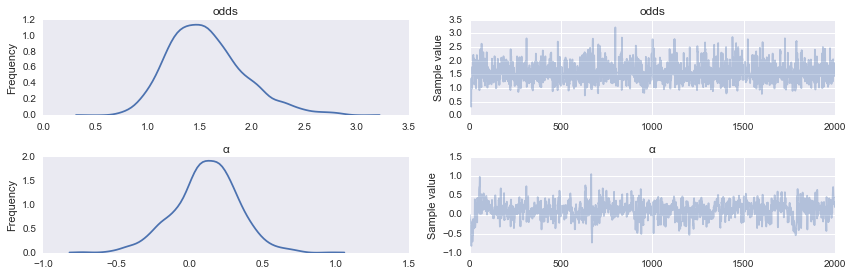

In [48]:
traceplot(full_zib_pooled_trace, varnames=['odds', 'α'])

In [49]:
waic(full_zib_pooled_trace, model=full_zib_pooled_model)

4986.15610415643